# Домашнее задание 3. Fine-Tuning модели BERT и анализ альтернативных архитектур в задаче классификации

**ФИО Студента:** Поликарпов Дмитрий Александрович

**Дата Выполнения:** 05.10.2025

---

### **Описание задания**

В этом задании вы реализуете эксперементальное сравнение классического трансформера (BERT) с современными альтернативными архитектурами (Mamba) на задаче классификации русскоязычных текстов. Проведете исследование trade-offs между качеством, скоростью и количеством обучаемых параметров для различных подходов к Fine-Tuning.
---

## **Установка и импорт библиотек**

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import warnings

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

from datasets import Dataset as HFDataset
import evaluate

from peft import (
    LoraConfig,
    TaskType,
    get_peft_model
)

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## **Задание 1. Подготовка данных и базовой модели**

Используем полный датасет русскоязычных отзывов с Кинопоиска. Для упрощения задачи бинарной классификации удаляем нейтральные отзывы. Разбиваем данные на обучающую и тестовую выборки в соотношении 80/20.

Задачи:
1. Загрузите датасет отзывов Кинопоиска и соответствующий токенизатор для DeepPavlov/rubert-base-cased.


In [5]:
# Загружаем полный датасет
print("Загружаем полный датасет отзывов...")
df_full = pd.read_json("hf://datasets/blinoff/kinopoisk/kinopoisk.jsonl", lines=True)

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

Загружаем полный датасет отзывов...


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Определим функции для токенизации, вычисления метрик и подсчета обучаемых параметров, которые будут использоваться для всех моделей.   

2. Подготовьте данные: создайте dataset-объекты для обучающей и тестовой выборок, токенизируйте тексты и подготовьте их к подаче в модель в соответствии с семинаром 1 данной дисциплины.  
3. Определите функцию для вычисления метрик Accuracy, F1-score.  




  

In [ ]:
MAX_LENGTH = 256 # Ограничиваем длину для ускорения обучения и экономии памяти

print("Удаляем нейтральные отзывы...")
df_binary = df_full[df_full['grade3'] != 'Neutral'].copy()
df_binary['label'] = df_binary['grade3'].apply(lambda x: 0 if x == 'Bad' else 1)

print("Разбиваем данные на train/test...")
train_df, test_df = train_test_split(
    df_binary,
    test_size=0.2,
    random_state=42,
    stratify=df_binary['label']
)

train_dataset = HFDataset.from_pandas(train_df)
test_dataset = HFDataset.from_pandas(test_df)

def tokenize_function(examples):
    return tokenizer(
        examples['content'], 
        padding=False,
        truncation=True,
        max_length=MAX_LENGTH
    )

print("Токенизируем тексты...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Размер обучающей выборки: {len(tokenized_train)}")
print(f"Размер тестовой выборки: {len(tokenized_test)}")
print(f"Распределение классов в обучающей выборке: {pd.Series(train_df['label']).value_counts().to_dict()}")
print(f"Распределение классов в тестовой выборке: {pd.Series(test_df['label']).value_counts().to_dict()}")

Удаляем нейтральные отзывы...
Разбиваем данные на train/test...
Токенизируем тексты...


Map:   0%|          | 0/25612 [00:00<?, ? examples/s]

Map:   0%|          | 0/6403 [00:00<?, ? examples/s]

Размер обучающей выборки: 25612
Размер тестовой выборки: 6403
Распределение классов в обучающей выборке: {1: 21811, 0: 3801}
Распределение классов в тестовой выборке: {1: 5453, 0: 950}


## **Задания 2 и 3. Baseline — Fine-Tuning BERT**

В качестве baseline используем русскоязычную модель `DeepPavlov/rubert-base-cased`. Мы рассмотрим два подхода: полный Fine-Tuning и эффективный Fine-Tuning с помощью LoRA.

Задачи:  
**BERT Full Fine-Tuning:**
1. Загрузите предобученную модель DeepPavlov/rubert-base-cased.
2. Настройте TrainingArguments для полного дообучения.
3. Обучите модель на полном обучающем наборе данных.
4. Оцените качество на тестовой выборке и зафиксируйте время обучения и количество обучаемых параметров.  

**BERT с LoRA или иным методом (Parameter-Efficient Fine-Tuning):**
1. Снова загрузите исходную модель DeepPavlov/rubert-base-cased.
2. Настройте LoraConfig, указав целевые модули (например, query, value).
3. Примените LoRA к модели с помощью get_peft_model.
4. Обучите параметро-эффективную модель.
5. Оцените ее качество, время обучения и количество обучаемых параметров.   
6. Сравните с результатами полного дообучения.

In [7]:
MODEL_NAME_BERT = "DeepPavlov/rubert-base-cased"

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

print("1. Загружаем модель DeepPavlov/rubert-base-cased...")
model_bert = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=2,
    ignore_mismatched_sizes=True
)

print("2. Подготавливаем данные для обучения...")
def prepare_dataset_for_training(dataset):
    dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ['input_ids', 'attention_mask', 'label']])
    return dataset

tokenized_train_clean = prepare_dataset_for_training(tokenized_train)
tokenized_test_clean = prepare_dataset_for_training(tokenized_test)

print("3. Настраиваем TrainingArguments...")
training_args = TrainingArguments(
    output_dir="./bert_full_finetuning",
    learning_rate=2e-5,
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    report_to=None,
    seed=42,
    dataloader_num_workers=2,
    gradient_accumulation_steps=1,
    fp16=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("4. Обучаем модель...")
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_train_clean,
    eval_dataset=tokenized_test_clean,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

start_time = time.time()
trainer_bert.train()
training_time_bert = time.time() - start_time


print("5. Оцениваем качество на тестовой выборке...")
bert_results = trainer_bert.evaluate(tokenized_test_clean)
trainable_params_bert = count_trainable_parameters(model_bert)

print("=== РЕЗУЛЬТАТЫ BERT FULL FINE-TUNING ===")
print(f"Accuracy: {bert_results['eval_accuracy']:.4f}")
print(f"F1-score: {bert_results['eval_f1']:.4f}")
print(f"Время обучения: {training_time_bert:.2f} секунд ({training_time_bert/60:.1f} минут)")
print(f"Обучаемые параметры: {trainable_params_bert:,}")

bert_full_results = {
    'accuracy': bert_results['eval_accuracy'],
    'f1': bert_results['eval_f1'],
    'training_time': training_time_bert,
    'trainable_params': trainable_params_bert
}

1. Загружаем модель DeepPavlov/rubert-base-cased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


2. Подготавливаем данные для обучения...
3. Настраиваем TrainingArguments...
4. Обучаем модель...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.134800,0.135220,0.954709,0.973574


5. Оцениваем качество на тестовой выборке...


=== РЕЗУЛЬТАТЫ BERT FULL FINE-TUNING ===
Accuracy: 0.9547
F1-score: 0.9736
Время обучения: 358.36 секунд (6.0 минут)
Обучаемые параметры: 177,854,978


In [ ]:
trainer_bert.save_model("./saved_bert_model")
tokenizer.save_pretrained("./saved_bert_model")

('./saved_bert_model/tokenizer_config.json',
 './saved_bert_model/special_tokens_map.json',
 './saved_bert_model/vocab.txt',
 './saved_bert_model/added_tokens.json',
 './saved_bert_model/tokenizer.json')

In [ ]:

print("1. Загружаем модель DeepPavlov/rubert-base-cased...")
model_bert_lora = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=2,
    ignore_mismatched_sizes=True
)

print("2. Настраиваем LoraConfig...")
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value", "key"]
)

print("3. Применяем LoRA к модели...")
model_bert_lora = get_peft_model(model_bert_lora, lora_config)

print("4. Настраиваем TrainingArguments для LoRA...")
training_args_lora = TrainingArguments(
    output_dir="./bert_lora_finetuning",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_lora",
    logging_steps=100,
    report_to=None,
    seed=42,
    dataloader_num_workers=2,
    gradient_accumulation_steps=1,
    fp16=True,
)

print("5. Обучаем модель с LoRA...")
trainer_lora = Trainer(
    model=model_bert_lora,
    args=training_args_lora,
    train_dataset=tokenized_train_clean,
    eval_dataset=tokenized_test_clean,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

start_time_lora = time.time()
trainer_lora.train()
training_time_lora = time.time() - start_time_lora

print("6. Оцениваем качество на тестовой выборке...")
lora_results = trainer_lora.evaluate(tokenized_test_clean)
trainable_params_lora = count_trainable_parameters(model_bert_lora)

print("=== РЕЗУЛЬТАТЫ BERT С LoRA ===")
print(f"Accuracy: {lora_results['eval_accuracy']:.4f}")
print(f"F1-score: {lora_results['eval_f1']:.4f}")
print(f"Время обучения: {training_time_lora:.2f} секунд ({training_time_lora/60:.1f} минут)")
print(f"Обучаемые параметры: {trainable_params_lora:,}")

lora_results_dict = {
    'accuracy': lora_results['eval_accuracy'],
    'f1': lora_results['eval_f1'],
    'training_time': training_time_lora,
    'trainable_params': trainable_params_lora
}

print("\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===")
print(f"Метрика           | BERT Full FT | BERT + LoRA  | Разница")
print(f"------------------|--------------|--------------|---------")
print(f"Accuracy          | {bert_full_results['accuracy']:.4f}     | {lora_results_dict['accuracy']:.4f}     | {lora_results_dict['accuracy'] - bert_full_results['accuracy']:+.4f}")
print(f"F1-score          | {bert_full_results['f1']:.4f}     | {lora_results_dict['f1']:.4f}     | {lora_results_dict['f1'] - bert_full_results['f1']:+.4f}")
print(f"Время обучения    | {bert_full_results['training_time']/60:.1f} мин    | {lora_results_dict['training_time']/60:.1f} мин    | {lora_results_dict['training_time'] - bert_full_results['training_time']:+.1f}с")
print(f"Обучаемые параметры | {bert_full_results['trainable_params']:,} | {lora_results_dict['trainable_params']:,} | {lora_results_dict['trainable_params']/bert_full_results['trainable_params']:.2%}")


=== ЗАДАНИЕ 3: BERT С LoRA ===
1. Загружаем модель DeepPavlov/rubert-base-cased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


2. Настраиваем LoraConfig...
3. Применяем LoRA к модели...
4. Настраиваем TrainingArguments для LoRA...
5. Обучаем модель с LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.145400,0.137914,0.946900,0.969012


6. Оцениваем качество на тестовой выборке...


=== РЕЗУЛЬТАТЫ BERT С LoRA ===
Accuracy: 0.9469
F1-score: 0.9690
Время обучения: 275.70 секунд (4.6 минут)
Обучаемые параметры: 443,906

=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===
Метрика           | BERT Full FT | BERT + LoRA  | Разница
------------------|--------------|--------------|---------
Accuracy          | 0.9547     | 0.9469     | -0.0078
F1-score          | 0.9736     | 0.9690     | -0.0046
Время обучения    | 6.0 мин    | 4.6 мин    | -82.7с
Обучаемые параметры | 177,854,978 | 443,906 | 0.25%


In [13]:
model_bert_lora.save_pretrained("./saved_bert_lora")
tokenizer.save_pretrained("./saved_bert_lora")

('./saved_bert_lora/tokenizer_config.json',
 './saved_bert_lora/special_tokens_map.json',
 './saved_bert_lora/vocab.txt',
 './saved_bert_lora/added_tokens.json',
 './saved_bert_lora/tokenizer.json')

## **Задание 4. Альтернативная архитектура — Mamba**

Mamba — это современная архитектура на основе пространств состояний (State Space Models), которая показывает высокую производительность и линейную сложность по длине последовательности. Используем небольшую предобученную модель `state-spaces/mamba-130m-hf`.

Архитектура еще не распространенная, поэтому нужно самостоятельно написать блок для классификатора последовательностей. Вы можете воспользоваться готовым кодом ниже для эксперимента, либо установить библиотеку https://github.com/getorca/mamba_for_sequence_classification, либо протестировать иные архитектуры с huggingface

Задачи:  
1. Загрузите предобученную модель Mamba или другую, подходящую для классификации текста (например, state-spaces/mamba-130m-hf).
2. Адаптируйте модель для задачи бинарной классификации (добавьте классификационную голову).
3. Настройте TrainingArguments и проведите Fine-Tuning модели Mamba.
Оцените ее итоговое качество, время обучения и количество параметров.


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
import time

MODEL_NAME_MAMBA = "state-spaces/mamba-130m-hf"
MAX_LENGTH = 256

tokenizer_mamba = AutoTokenizer.from_pretrained(MODEL_NAME_MAMBA)
if tokenizer_mamba.pad_token is None:
    tokenizer_mamba.pad_token = tokenizer_mamba.eos_token

def tokenize_mamba_function(examples):
    return tokenizer_mamba(
        examples['content'],
        padding="max_length", 
        truncation=True,
        max_length=MAX_LENGTH
    )

tokenized_train_mamba = train_dataset.map(tokenize_mamba_function, batched=True)
tokenized_test_mamba = test_dataset.map(tokenize_mamba_function, batched=True)

columns_to_keep = ["input_ids", "attention_mask", "label"]
tokenized_train_mamba.set_format(type="torch", columns=columns_to_keep)
tokenized_test_mamba.set_format(type="torch", columns=columns_to_keep)

class CustomMambaForSequenceClassification(nn.Module):
    def __init__(self, model_name=MODEL_NAME_MAMBA, num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.mamba = AutoModel.from_pretrained(model_name)
        hidden_size = self.mamba.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.mamba(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state.mean(dim=1)
        logits = self.classifier(cls_embedding)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=None
        )

model_mamba = CustomMambaForSequenceClassification(num_labels=2)
model_mamba.mamba.config.pad_token_id = tokenizer_mamba.pad_token_id

training_args_mamba = TrainingArguments(
    output_dir="./results/mamba_custom",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./logs/mamba_custom',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_mamba)

trainer_mamba = Trainer(
    model=model_mamba,
    args=training_args_mamba,
    train_dataset=tokenized_train_mamba,
    eval_dataset=tokenized_test_mamba,
    tokenizer=tokenizer_mamba,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

start_time = time.time()
trainer_mamba.train()
train_time = time.time() - start_time

eval_results = trainer_mamba.evaluate()

mamba_results_dict = {
    'accuracy': eval_results['eval_accuracy'],
    'f1': eval_results['eval_f1'],
    'training_time': train_time,
    'trainable_params': count_trainable_parameters(model_mamba)
}

print(f"\n=== РЕЗУЛЬТАТЫ MAMBA FINE-TUNING ===")
print(f"Accuracy: {mamba_results_dict['accuracy']:.4f}")
print(f"F1-Score: {mamba_results_dict['f1']:.4f}")
print(f"Training Time: {mamba_results_dict['training_time']:.2f} секунд ({mamba_results_dict['training_time']/60:.1f} минут)")
print(f"Trainable Params: {mamba_results_dict['trainable_params']:,}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/25612 [00:00<?, ? examples/s]

Map:   0%|          | 0/6403 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.264800,0.223598,0.930814,0.959584



=== РЕЗУЛЬТАТЫ MAMBA FINE-TUNING ===
Accuracy: 0.9308
F1-Score: 0.9596
Training Time: 809.62 секунд (13.5 минут)
Trainable Params: 129,136,898


## **Задание 5. Сравнительный анализ и выводы**

Проведите сравнительный анализ подходов и сделайте выводы на основе проведенных эксперементов.

Задачи:  
1. Создайте сводную таблицу, в которой будут отражены все ключевые показатели для трех подходов:
- BERT Full Fine-Tuning
- BERT + LoRA
- Mamba
2. Сравните модели по следующим критериям:
- Качество: Accuracy и F1-score.
- Эффективность: время обучения и количество обучаемых параметров.

3. Сформулируйте развернутые выводы:
- Какой подход показал наилучшее качество?
- Насколько LoRA сокращает количество параметров и время обучения по сравнению с полным Fine-Tuning? Как это влияет на метрики?
- Как Mamba показывает себя в сравнении с BERT? В чем ее сильные и слабые стороны для данной задачи?

4. Дайте рекомендации по выбору архитектуры в зависимости от ограничений (время, вычислительные ресурсы, требования к качеству).


=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
Метод                | Accuracy | F1       | Время (мин)  | Параметры       | % от FT   
------------------------------------------------------------------------------------------
BERT Full FT         | 0.9547  | 0.9736  |        6.0 |   177,854,978 |    100.0%
BERT + LoRA          | 0.9469  | 0.9690  |        4.6 |       443,906 |      0.2%
Mamba                | 0.9308  | 0.9596  |       13.5 |   129,136,898 |     72.6%


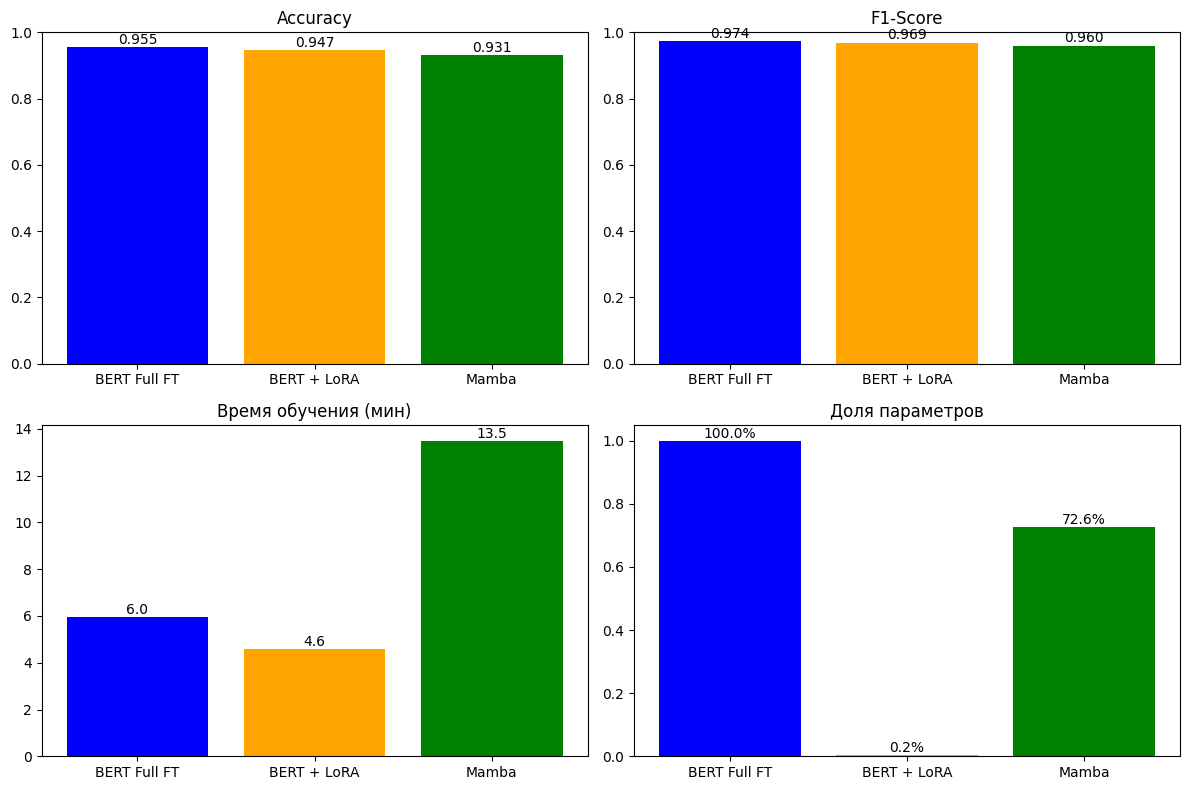

In [ ]:
print("=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===")
print("\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 90)
print(f"{'Метод':<20} | {'Accuracy':<8} | {'F1':<8} | {'Время (мин)':<12} | {'Параметры':<15} | {'% от FT':<10}")
print("-" * 90)

results_summary = {
    'BERT Full FT': bert_full_results,
    'BERT + LoRA': lora_results_dict,
    'Mamba': mamba_results_dict
}

for method, results in results_summary.items():
    params_percent = (results['trainable_params'] / bert_full_results['trainable_params']) * 100
    print(f"{method:<20} | {results['accuracy']:.4f}  | {results['f1']:.4f}  | {results['training_time']/60:10.1f} | {results['trainable_params']:>13,} | {params_percent:>8.1f}%")

print("=" * 90)

methods = list(results_summary.keys())
accuracy = [results['accuracy'] for results in results_summary.values()]
f1_scores = [results['f1'] for results in results_summary.values()]
times = [results['training_time']/60 for results in results_summary.values()]
params_ratio = [results['trainable_params']/bert_full_results['trainable_params'] for results in results_summary.values()]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

bars1 = ax1.bar(methods, accuracy, color=['blue', 'orange', 'green'])
ax1.set_title('Accuracy')
ax1.set_ylim(0, 1)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center')

bars2 = ax2.bar(methods, f1_scores, color=['blue', 'orange', 'green'])
ax2.set_title('F1-Score')
ax2.set_ylim(0, 1)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center')

bars3 = ax3.bar(methods, times, color=['blue', 'orange', 'green'])
ax3.set_title('Время обучения (мин)')
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.1f}', ha='center')

bars4 = ax4.bar(methods, params_ratio, color=['blue', 'orange', 'green'])
ax4.set_title('Доля параметров')
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.1%}', ha='center')

plt.tight_layout()
plt.show()

### Сравнительный анализ подходов

1. Качество моделей:
- `BERT Full Fine-Tuning` показал наилучшее качество: `Accuracy = 0.9547, F1 = 0.9736`. Вся модель обучается на задаче и она максимально адаптирована под данные.
- `BERT + LoRA` продемонстрировал чуть более низкое качество: `Accuracy = 0.9469, F1 = 0.9690`. Разница с полным Fine-Tuning подтверждает, что `LoRA` позволяет эффективно дообучать модель с минимальным числом параметров.
- `Mamba` показала качество ниже `BERT`: `Accuracy = 0.9308, F1 = 0.9596`. Результат остаётся достаточно высоким, хотя уступает `BERT`.

2. Эффективность:
- `BERT Full FT` требует максимального числа параметров (≈178 млн) и относительно короткого времени обучения - 6 минут на данном наборе данных.
- `BERT + LoRA` резко сокращает количество обучаемых параметров до 0.2% от полного FT (≈444 тыс.), при этом экономит время обучения (4.6 минуты) и почти не теряет в качестве.
- `Mamba` обладает большим числом параметров (≈129 млн, 72.6% от `BERT Full FT`) и значительным временем обучения - 13.5 минут, что можно объяснить линейной сложностью SSM.

**Выводы по подходам:**
- Лучшее качество достигается через полный `Fine-Tuning BERT`.
- `LoRA` позволяет сильно экономить ресурсы при минимальной потере качества. 
- `Mamba` показывает, что новые архитектуры на основе SSM могут давать хорошие результаты, но требуют больше ресурсов и времени на обучение.

### Выводы по экспериментам:
1. Наилучшее качество показал `BERT Full Fine-Tuning`
2. `BERT + LoRA`:
- Количество обучаемых параметров сокращено почти в 500 раз: с ≈178 млн до ≈444 тыс. (0.2% от полного FT).
- Время обучения также уменьшилось: 4.6 минуты против 6 минут у полного Fine-Tuning.
- При этом метрики практически не пострадали: `Accuracy = 0.9469, F1 = 0.9690`.

**Вывод:** `LoRA` позволяет экономить ресурсы и ускорять обучение без значимой потери качества.

3. `Mamba`:
- Качество чуть ниже `BERT`: `Accuracy = 0.9308, F1 = 0.9596`.
- Время обучения больше: 13.5 минут, число параметров ≈129 млн (≈73% от `BERT Full FT`).

**Сильные стороны:**
- Архитектура на основе SSM хорошо масштабируется на длинные последовательности.
- Подходит для экспериментов с новыми архитектурами.

**Слабые стороны:**
- Более высокие вычислительные затраты на обучении.
- Немного уступает `BERT` по точности на коротких текстах.

### Рекомендации по выбору архитектуры
1. Если приоритет — максимальное качество:
- Выбор: `BERT Full Fine-Tuning`
- Плюсы: Высокие метрики (`Accuracy ≈ 0.95, F1 ≈ 0.97`).
- Минусы: Требует полного набора ресурсов, больше обучаемых параметров (~178 млн).

2. Если ограничены вычислительные ресурсы или нужно быстро дообучать модель:
- Выбор: `BERT + LoRA`
- Плюсы: Минимальные обучаемые параметры (~0.2% от полного `BERT`), сокращение времени обучения (≈4.6 мин), метрики остаются почти на уровне полного FT.
- Минусы: Небольшая потеря точности по сравнению с полным Fine-Tuning.

3. Если важна работа с длинными последовательностями
- Выбор: `Mamba`
- Плюсы: Линейная сложность по длине последовательности, современная архитектура SSM, хорошие метрики для длинных текстов.
- Минусы: Более высокие затраты на обучение, время обучения выше (≈13.5 мин), немного уступает `BERT` по точности на коротких текстах.